In [1]:
import numpy as np
import numba
import sklearn.datasets
import umap
import pynndescent
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.sparse
import sklearn.metrics

from collections import namedtuple
from sklearn.preprocessing import normalize

sns.set(rc={"figure.figsize":(12, 12)})

/work/home/vmpouli/.conda/envs/prob_high_d_clustering/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/work/home/vmpouli/.conda/envs/prob_high_d_clustering/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/work/home/vmpouli/.conda/envs/p

## Build the Graph

The goal is to contruct a graph with edge weights given by estimating the probability of being the nearest neighbor. How can we estimate such a probability? Surely the sample is either the nearest neighbor or it isn't? We assume sampling has been random and somewhat noisy; but that the distribution of samples is *locally* uniform. In other words we assume that in a local region there is a distribution of distances to the nearest neighbor. This distribution is asymptotically a Gamma distribution; since we are in high dimensions this can be well approximated by a normal distribution (which is much cheaper to model, and to compute probabilities for). Thus for each sample we consider it's local neighborhood and fit a model of the distance to the nearest neighbor for samples in that neighborhood. Given such a model we can then compute the probability that the nearest neighbor of the sample is at least as far away as any given sample, and thus create an edge with w weight given by the probability that this point would have been the nearest neighbor under our model. This provides a (directed!) graph with proabiulities assigned to edges.

In [2]:
@numba.njit(fastmath=True)
def update_model_using_sample_estimate(mu_0, nu, alpha, beta, sample_mean, sample_var, sample_n):
    
    alpha = alpha + sample_n/2
    beta = beta + (sample_n * sample_var) / 2 + (sample_n * nu * (mu_0 - sample_mean)**2 / (2 * (sample_n + nu)))
    mu = (mu_0 * nu + sample_mean * sample_n) / (nu + sample_n)
    sigma = np.sqrt(beta / (alpha + 1))
    
    return mu, sigma

@numba.njit()
def propagate_models(nn_inds, model_mus, model_sigmas, model_nus, model_alphas, model_betas):
    
    result_mus = model_mus.copy()
    result_sigmas = model_sigmas.copy()
    result_nus = model_nus.copy()
    result_alphas = model_alphas.copy()
    result_betas = model_betas.copy()
    
    sample_n = nn_inds.shape[1] - 1
    
    for i in range(nn_inds.shape[0]):
        sample_mean = 0.0
        sample_var = 0.0
        for j in range(nn_inds.shape[1]):
            k = nn_inds[i, j]
            if k == i:
                continue
            
            # result_alphas[i] += model_nus[k] / 2.0
            # result_betas[i] += (
            #     model_nus[k] * model_sigmas[k] / 2.0 + 
            #     model_nus[k] * result_nus[i] * (result_mus[i] - model_mus[k]) ** 2 /
            #     (2 * (model_nus[k] + result_nus[i]))
            # )
            result_mus[i] = (result_mus[i] * result_nus[i] + model_mus[k] * model_nus[k]) / (result_nus[i] + model_nus[k])
            # This division is performed at each step but only used at the end of second loop
            # result_sigmas[i] = result_betas[i] / (result_alphas[i] + 1)
            result_nus[i] += model_nus[k]
        
    return result_mus, result_sigmas, result_nus, result_alphas, result_betas

@numba.njit()
def build_models_prop(nn_inds, nn_dists, n_iter=3, prior_strength=0.05):
    
    model_mus = (1.0 - prior_strength) * nn_dists + prior_strength * np.mean(nn_dists)
    model_sigmas = np.zeros_like(nn_dists)
    model_nus = np.ones_like(nn_dists)# + prior_strength
    model_alphas = np.ones_like(nn_dists) / 2.0
    model_betas = np.var(nn_dists) * model_alphas # np.zeros_like(nn_dists)
    
    for i in range(n_iter):
        model_mus, model_sigmas, model_nus, model_alphas, model_betas = propagate_models(
            nn_inds, model_mus, model_sigmas, model_nus, model_alphas, model_betas
        )
    
    return np.vstack((model_mus, np.sqrt(model_sigmas))).T


# Test matrix multiplication for mu propagation

In [3]:
# @numba.njit()
def build_models_prop_mus(nn_inds, nn_dists, n_iter=3, prior_strength=0.05):
    
    model_mus = (1.0 - prior_strength) * nn_dists + prior_strength * np.mean(nn_dists)
    
    kk = len(nn_inds[0])
    
    i_list = list()
    j_list = list()
    for i, x in enumerate(nn_inds):
        for j in x:
            i_list.append(i)
            j_list.append(j)
    data = [1]*len(i_list)
    
    A =  1.0/kk*scipy.sparse.coo_matrix((data, (i_list, j_list)))
    
    for i in range(n_iter):
        model_mus = A*model_mus
    
    return model_mus



In [4]:
mnist = sklearn.datasets.fetch_openml("mnist_784")
mnist_data = mnist.data

/work/home/vmpouli/.conda/envs/prob_high_d_clustering/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [5]:
data = mnist_data
metric="euclidean"
min_cluster_size=800
n_neighbors=30
max_iter=50
label_prior=0.99
noise_prior=0.01
max_total_weight=64.0
k=1
min_prob=1e-4
model_prior_strength=0.0
n_iter=3
tolerance=1e-5
m=n_neighbors

In [6]:
prior_strength=model_prior_strength
nn_index = pynndescent.NNDescent(data, metric=metric, n_neighbors=n_neighbors, n_trees=8, max_candidates=20)
nn_inds, nn_dists = nn_index.neighbor_graph


# models = build_models_prop(
#     nn_inds[:, :m], nn_dists[:, k], n_iter=n_iter, prior_strength=prior_strength
# )
nn_inds_input = nn_inds[:, :m]
nn_dists_input = nn_dists[:, k]

## Check on data

In [7]:
%%time
x = build_models_prop_mus(nn_inds, nn_dists_input, n_iter=3, prior_strength=0.05)

CPU times: user 761 ms, sys: 39.9 ms, total: 801 ms
Wall time: 800 ms


In [8]:
%%time
y = build_models_prop(nn_inds, nn_dists_input, n_iter=3, prior_strength=0.05)

CPU times: user 806 ms, sys: 32 ms, total: 838 ms
Wall time: 837 ms


In [9]:
max([abs(x[i]-y[i,0]) for i in range(len(x))])

0.0004200415618242914

In [10]:
sum([abs(x[i]-y[i,0]) for i in range(len(x))])

28.361988969254583

# Study the propagation matrix

The principal eigenvector of A is associated to the eigenvalue 1 (all the others are smaller than 1). It depends on the strongly connected components (SCCs) of the matrix. The matrix can be decomposed into blocks associated to each of the SCCs. If we think contract these SCCs into vertices, we are left with a directed acyclic graph (DAG). A number of the SCCs are sinks.

* See https://link.springer.com/article/10.1007/s10618-009-0154-1

In [11]:
kk = len(nn_inds[0])
    
i_list = list()
j_list = list()
for i, x in enumerate(nn_inds):
    for j in x:
        i_list.append(i)
        j_list.append(j)
data = [1]*len(i_list)

A =  1.0/kk*scipy.sparse.coo_matrix((data, (i_list, j_list)))
A = A.tocsr()

In [12]:
nb_scc, scc = scipy.sparse.csgraph.connected_components(A, connection='strong')

In [13]:
nb_scc

324

In [14]:
kth_nn_dists = nn_dists[:,k]
model_mus = (1.0 - prior_strength) * kth_nn_dists + prior_strength * np.mean(kth_nn_dists)

In [15]:
for i in range(50000):
    model_mus = A*model_mus

In [16]:
import pandas as pd
df = pd.DataFrame({'scc':scc, 'limit_value':model_mus})

In [17]:
df.scc.value_counts()

scc
0      69665
215        4
26         2
22         2
65         2
       ...  
112        1
111        1
110        1
109        1
323        1
Name: count, Length: 324, dtype: int64

In [18]:
# sns.boxplot(df, x='scc', y='limit_value')

In [19]:
A_scc = A[scc==0,:][:, scc==0]

In [20]:
eig_val, eig_vec = scipy.sparse.linalg.eigs(A_scc, k=1)

In [21]:
eig_val_mult =  scipy.sparse.linalg.eigs(A_scc, k=200, return_eigenvectors=False)

/work/home/vmpouli/.conda/envs/prob_high_d_clustering/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


<Axes: >

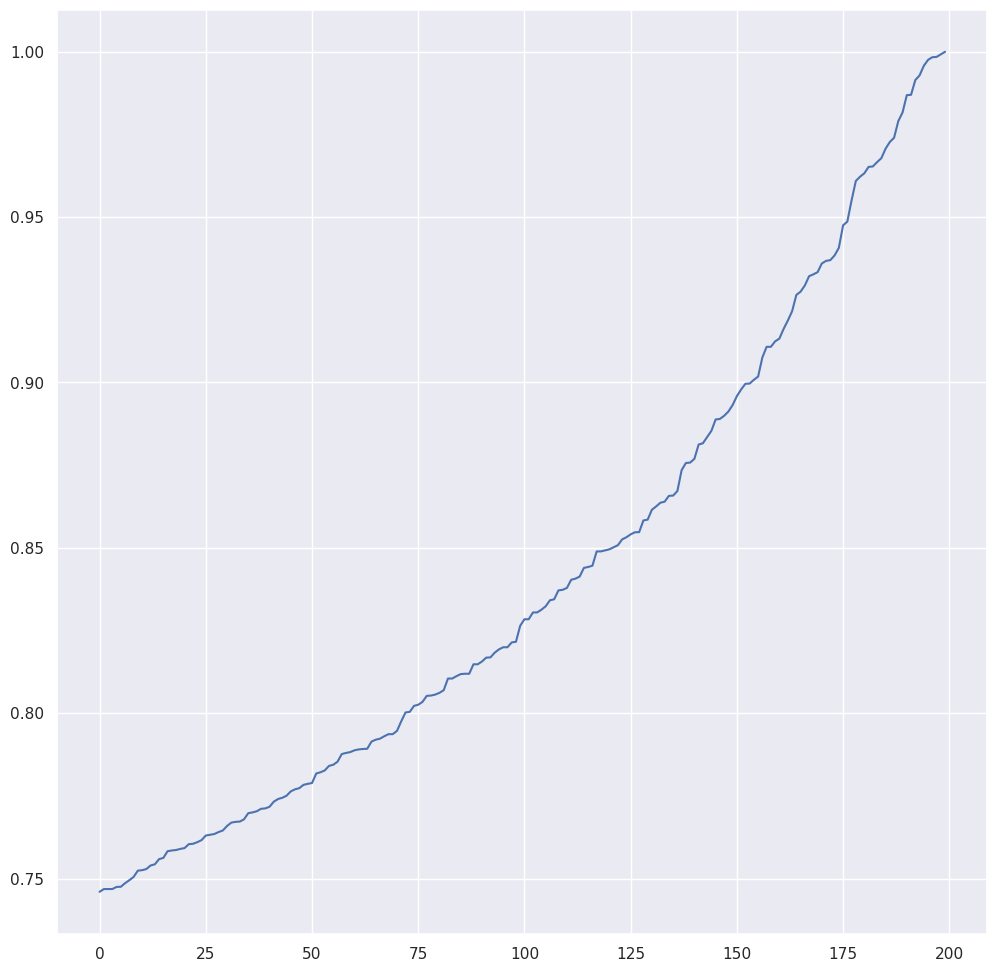

In [22]:
sns.lineplot(eig_val_mult)

In [35]:
eig_val_T, eig_vec_T = scipy.sparse.linalg.eigs(A_scc.T, k=1)

In [38]:
M = np.matmul(eig_vec, eig_vec_T.T)

In [43]:
M[0:3, 0:3]

array([[5.32254971e-16+0.j, 1.76220978e-11+0.j, 4.92323260e-14+0.j],
       [5.32254971e-16+0.j, 1.76220978e-11+0.j, 4.92323260e-14+0.j],
       [5.32254971e-16+0.j, 1.76220978e-11+0.j, 4.92323260e-14+0.j]])

/work/home/vmpouli/.conda/envs/prob_high_d_clustering/lib/python3.11/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


<Axes: >

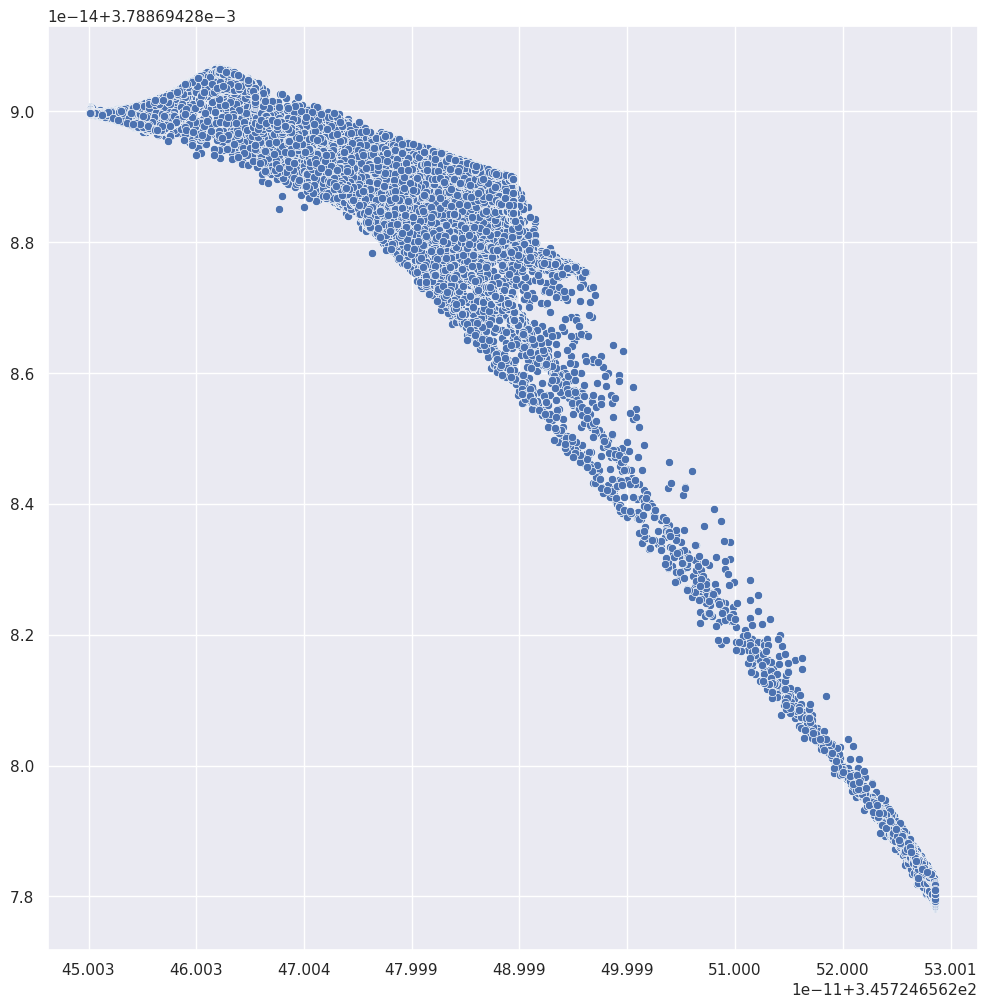

In [61]:
sns.scatterplot(x=model_mus[scc==0], y=eig_vec[:,0])